# Dots and Boxes using Reinforcement Learning

_by Apoorv Pandey_

## Introduction

This project involved:
* Creating a 2-player game-playing program to play [2x2](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Dots-and-boxes.svg/2000px-Dots-and-boxes.svg.png) [Dots and Boxes](https://en.wikipedia.org/wiki/Dots_and_Boxes) using neural network reinforcement learning.
* The objective was to train the program so that both players learned to play in the most optimal way possible.

## Q Network

Instead of a tabular implementation for Q, a neural network is used for the reinforcement learning instead.

When using a Q table, the predicted value if the state is not seen/explored previously is 0. However, in a neural network implementation, even if a state is previously unseen/unexplored, a value is generated based on the likeliness of the state to previous states. This should theoretically improve the rate of learning of the reinforcement algorithm, however in practice this is generally not the case, because determining the weights for each layer in the neural network is a challenge.

Basic algorithm of the training is:
* For number of batches, repeat the following:
    * Initialize an empty sample list.
    * Repeat for number of repetitions per batch:
        * Initialize the starting state.
        * Play the game till completion (using `epsilonGreedy` to choose a move).
            * When game is over, determine the appropriate reinforcement and add it to samples.
    * Extract the state + move (25 values) from each sub-list in state as weights, and the reinforcement value and `Qnext` value (values 26 and 27) from each state, whose sum serves as the target.
    * Train the neural network `Qnet` using these data points.

### Functions

The functions implemented for handling the training of the Q network are:
* `epsilonGreedy(Qnet, state, epsilon, validMovesF, turn)`: Returns the next move to be taken by the algorithm; allows for either a random move or a greedy move.
* `trainQnet(nBatches, nRepsPerBatch, hiddenLayers, nIterations, nReplays, epsilon, epsilonDecayFactor, validMovesF, makeMoveF, boxesCreatedF)`: This function trains the neural network which will serve as the Q function; it returns a trained neural network along with the outcomes and samples.
* `drawQnet(network)`: Displays a trained neural network, with the weights at each intermediate layer, how they combine to produce weights for the next layer and so on.

In [1]:
import numpy as np
import torch
import neuralnetwork1 as nn

import random
from copy import copy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cuda_available = torch.cuda.is_available()

In [3]:
def tensor(np_array):
    tensor = torch.from_numpy(np_array).double().cuda() if cuda_available else torch.from_numpy(np_array).double()
    return tensor

In [4]:
def epsilon_greedy(Qnet, state, epsilon, valid_moves_F, turn):
    moves = valid_moves_F(state)
    if np.random.uniform() < epsilon: # Random move
        move = moves[random.sample(range(len(moves)), 1)[0]]
        Q = Qnet.use_pytorch(tensor(np.array(start_state + [move]))) if Qnet.Xmeans is not None else 0
    else: # Greedy move
        Qs = []
        for m in moves:
            Qs.append(Qnet.use_pytorch(tensor(np.array(start_state + [m]))) if Qnet.Xmeans is not None else 0)
        move = moves[np.argmax(Qs)] if turn else moves[np.argmin(Qs)]
        Q = np.max(Qs) if turn else np.min(Qs)
    return move, Q

In [5]:
def train_Qnet(n_batches, n_reps_per_batch, network, n_iterations, learning_rate,
               epsilon, epsilon_decay_factor, valid_moves_F, make_move_F, boxes_created_F, relu=False, use_SGD=False):
    
    # use CUDA cores if available, else use CPU
    Qnet = nn.PyTorchNN(25, network, 1, relu).to(torch.device('cuda' if cuda_available else 'cpu')).double()
    repk = -1
    outcomes = np.zeros(n_batches*n_reps_per_batch)
    
    for batch in range(n_batches):
        if batch > 0:
            epsilon *= epsilon_decay_factor
            epsilon = max(0.01, epsilon) # Minimum learning rate is 0.01
        samples = []
        
        for reps in range(n_reps_per_batch):
            repk += 1
            
            # Initialize game
            state = [0]*24
            boxes = [0]*9
            score = [0]*2
            done = False
            
            # Start game; player 1's turn initially
            turn = True
            move, _ = epsilon_greedy(Qnet, state, epsilon, valid_moves_F, turn)
            
            # Continue to play the game
            while not done:
                r = 0
                state_next = make_move_F(state, move)
                created, boxes = boxes_created_F(state_next, boxes) # Check if a box is created after making move
                
                if created: # If a box is created, update score of the player who made the move
                    if turn:
                        score[0] += 1
                    else:
                        score[1] += 1
                else: # Else give turn to the other player
                    turn = not turn
                
                if 0 not in state_next: # If there are no more edges remaining, the game is over
                    done = True # Set termination flag
                    Qnext = 0 # Determine the reinforcement
                    r = 1 if score[0] > score[1] else -1
                    outcomes[repk] = r
                    #move_next = -1
                else: # Else, determine next move and add current sample with reinforcement 0
                    move_next, Qnext = epsilon_greedy(Qnet, state_next, epsilon, valid_moves_F, turn)
                
                samples.append([*state, move, r, Qnext]) # Collect turn results as a sample
                state = state_next
                move = move_next
        
        samples = np.array(samples) # Samples contains the training inputs and the targets
        X = tensor(samples[:, :25]) # Training inputs to the neural network
        T = tensor(samples[:, 25:26]+samples[:, 26:27]) # Target values for the neural network
        Qnet, _ = Qnet.train_pytorch(X, T, learning_rate, n_iterations, use_SGD) # Training the neural network
    
    print('DONE')
    return Qnet, outcomes, samples

In [6]:
def print_game(state):
    for i in range(4):
        for j in range(4):
            print('\u2022', end = '')
            if j == 3:
                print()
            else:
                if state[((3*i)+j)] == 1:
                    print('---', end = '')
                else:
                    print('   ', end = '')
        if i != 3:
            if(state[((4*i)+12)] == 1):
                if(state[((4*i)+13)] == 0 and state[((4*i)+14)] == 0 and state[((4*i)+15)] == 0):
                    print('|')
                else:
                    print('|', end = '')
            if(state[((4*i)+13)] == 1):
                if(state[((4*i)+14)] == 0 and state[((4*i)+15)] == 0):
                    print('   |')
                else:
                    print('   |', end = '')
            if(state[((4*i)+14)] == 1):
                if(state[((4*i)+15)] == 0):
                    print('   |')
                else:
                    print('   |', end = '')
            if(state[((4*i)+15)] == 1):
                print('   |')
            if(state[((4*i)+12)] == 0 and state[((4*i)+13)] == 0 and state[((4*i)+14)] == 0
               and state[((4*i)+15)] == 0):
                print()

In [7]:
def valid_moves(state):
    return list(np.where(np.array(state) == 0)[0])

In [8]:
def make_move(state, move):
    newState = state.copy()
    newState[move] = 1
    return newState

In [9]:
def box_created(state, boxes):
    created = False
    k = 0
    for i in range(9):
        if i != 0 and (i%3) == 0:
            k += 1
        if state[i] == 1 and state[(i+3)] == 1 and state[(i+12+k)] == 1 and state[(i+13+k)] == 1:
            if boxes[i] == 0:
                created = True
                boxes[i] = 1
    return created, boxes

In [10]:
def print_prediction(state):
    for i in range(4):
        for j in range(4):
            print('    \u2022    ', end = '')
            if j == 3:
                print()
            else:
                print(state[(3*i)+j], end = '')
        if i != 3:
            print(state[(4*i)+12], '    ', state[(4*i)+13], '    ', state[(4*i)+14], '    ', state[(4*i)+15])

In [11]:
def plot_outcomes(outcomes, max_games, n_games):
    if n_games == 0:
        return
    n_bins = 100
    n_per = int(max_games/n_bins)
    outcome_rows = outcomes.reshape(-1, n_per)
    outcome_rows = outcome_rows[:int(n_games/float(n_per))+1, :]
    avgs = np.mean(outcome_rows, axis = 1)
    xs = np.linspace(n_per, n_games, len(avgs))
    plt.figure(figsize = (15, 10))
    plt.plot(xs,np.sum(outcome_rows == 1, axis = 1),'g-',label='P1 wins')
    plt.plot(xs,np.sum(outcome_rows == -1, axis = 1),'r-',label='P2 wins')
    plt.plot(xs,np.sum(outcome_rows == 0, axis = 1),'b-',label='Draws')
    plt.legend(loc = "center")
    plt.ylabel('Number of Games\nin Bins of {:d}'.format(n_per))

In [12]:
start_state = [0]*24

In [13]:
print_game(start_state)

•   •   •   •

•   •   •   •

•   •   •   •

•   •   •   •


In [14]:
valid_moves(start_state)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [15]:
make_move(start_state, 1)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [16]:
print_game(make_move(start_state, 1))

•   •---•   •

•   •   •   •

•   •   •   •

•   •   •   •


In [17]:
example_state = make_move(start_state, 3)
print(example_state)
print()
print_game(make_move(start_state, 3))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

•   •   •   •

•---•   •   •

•   •   •   •

•   •   •   •


In [18]:
boxes = [1] + [0]*8

is_box_created_state_1 = make_move(make_move(make_move(make_move(make_move(make_move([0]*24, 0), 3), 12), 13), 1), 4)
print_game(is_box_created_state_1)
created, boxes = box_created(is_box_created_state_1, boxes)
print()
print(created)
print()
print(boxes)

is_box_created_state_2 = make_move(is_box_created_state_1, 14)
print_game(is_box_created_state_2)
created, boxes = box_created(is_box_created_state_2, boxes)
print()
print(created)
print()
print(boxes)

•---•---•   •
|   |
•---•---•   •

•   •   •   •

•   •   •   •

False

[1, 0, 0, 0, 0, 0, 0, 0, 0]
•---•---•   •
|   |   |
•---•---•   •

•   •   •   •

•   •   •   •

True

[1, 1, 0, 0, 0, 0, 0, 0, 0]


In [19]:
n_batches = 20
n_reps_per_batch = 1000
n_iterations = 50
network = [5, 5, 5]
learning_rate = 0.001
epsilon = 1
epsilon_decay_factor = 0.98

In [20]:
Qnet1, outcomes1, samples1 = train_Qnet(n_batches, n_reps_per_batch, network, n_iterations, learning_rate,
                                        epsilon, epsilon_decay_factor, valid_moves, make_move, box_created)

DONE


In [21]:
start_state = [0]*24
Q1s = [Qnet1.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q1s)

    •    [-0.07033844]    •    [-0.06751067]    •    [-0.06519706]    •    
[-0.05821041]      [-0.05813737]      [-0.05809162]      [-0.05806535]
    •    [-0.06336621]    •    [-0.06195243]    •    [-0.06087892]    •    
[-0.05805271]      [-0.05804936]      [-0.05805211]      [-0.05805867]
    •    [-0.06007323]    •    [-0.05947426]    •    [-0.05903328]    •    
[-0.05806741]      [-0.05807719]      [-0.05808725]      [-0.05809708]
    •    [-0.05871244]    •    [-0.05848253]    •    [-0.05832099]    •    


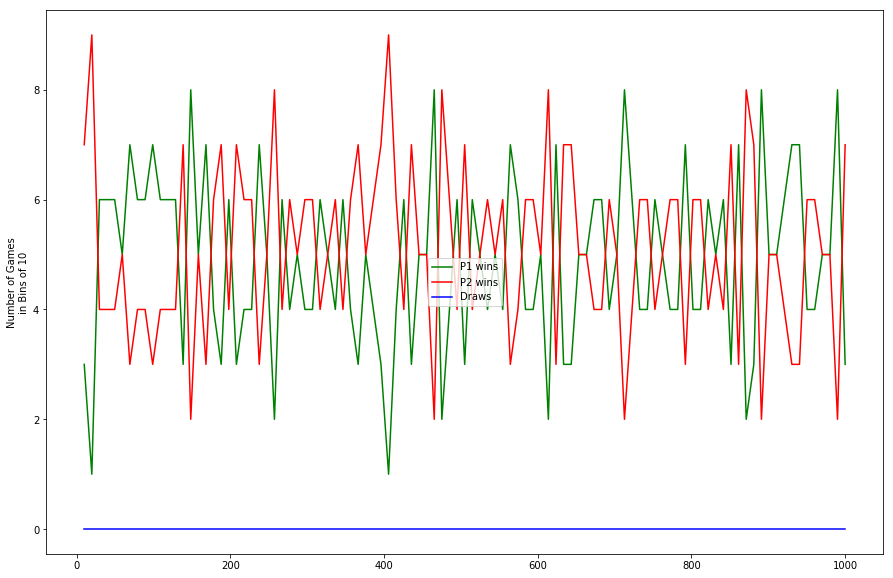

In [22]:
plot_outcomes(outcomes1, 1000, 1000)

In [23]:
n_batches = 50
n_reps_per_batch = 1000
n_iterations = 100
network = [20, 20, 20]
learning_rate = 0.001
epsilon = 1
epsilon_decay_factor = 0.95

In [24]:
Qnet2, outcomes2, samples2 = train_Qnet(n_batches, n_reps_per_batch, network, n_iterations, learning_rate,
                                        epsilon, epsilon_decay_factor, valid_moves, make_move, box_created)

DONE


In [25]:
start_state = [0]*24
Q2s = [Qnet2.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q2s)

    •    [0.02322875]    •    [0.04081595]    •    [0.05722707]    •    
[0.11752003]      [0.1193077]      [0.12096028]      [0.12253886]
    •    [0.07099362]    •    [0.08203677]    •    [0.0907077]    •    
[0.1240883]      [0.12564036]      [0.12721656]      [0.12883054]
    •    [0.09748073]    •    [0.10280055]    •    [0.10702215]    •    
[0.13048998]      [0.13219821]      [0.13395545]      [0.13575972]
    •    [0.11041635]    •    [0.11319255]    •    [0.11551643]    •    


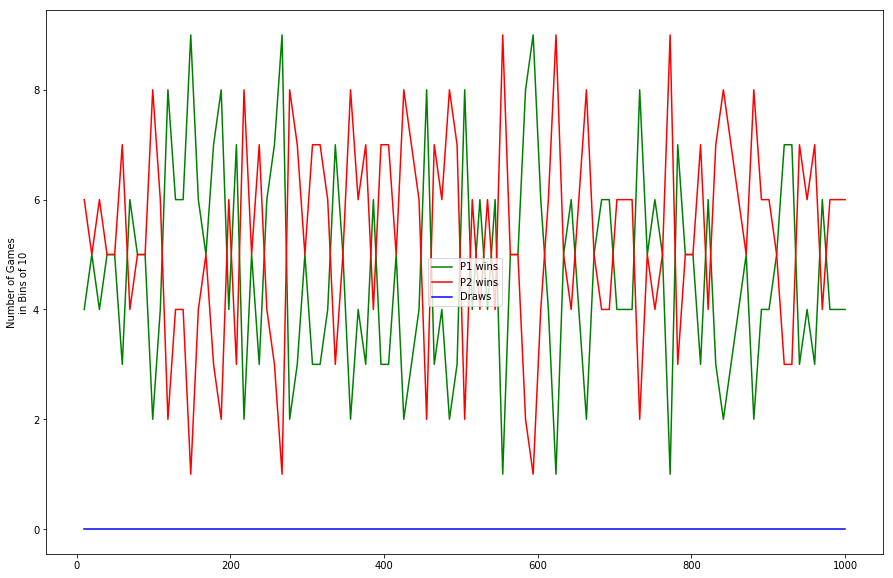

In [26]:
plot_outcomes(outcomes2, 1000, 1000)

In [27]:
n_batches = 100
n_reps_per_batch = 1000
n_iterations = 500
network = [100, 100, 100]
learning_rate = 0.001
epsilon = 1
epsilon_decay_factor = 0.92

In [28]:
Qnet3, outcomes3, samples3 = train_Qnet(n_batches, n_reps_per_batch, network, n_iterations, learning_rate,
                                        epsilon, epsilon_decay_factor, valid_moves, make_move, box_created)

DONE


In [29]:
start_state = [0]*24
Q3s = [Qnet3.use_pytorch(tensor(np.array(start_state + [m]))) for m in range(24)]
print_prediction(Q3s)

    •    [-0.8210924]    •    [-0.80774301]    •    [-0.81476195]    •    
[-0.85076521]      [-0.85422317]      [-0.85844709]      [-0.86283333]
    •    [-0.83409112]    •    [-0.83680879]    •    [-0.83054756]    •    
[-0.86682358]      [-0.87012624]      [-0.87269946]      [-0.87463759]
    •    [-0.83309329]    •    [-0.83780884]    •    [-0.84181324]    •    
[-0.87607635]      [-0.87714402]      [-0.87794488]      [-0.87855787]
    •    [-0.84461312]    •    [-0.84653503]    •    [-0.8483223]    •    


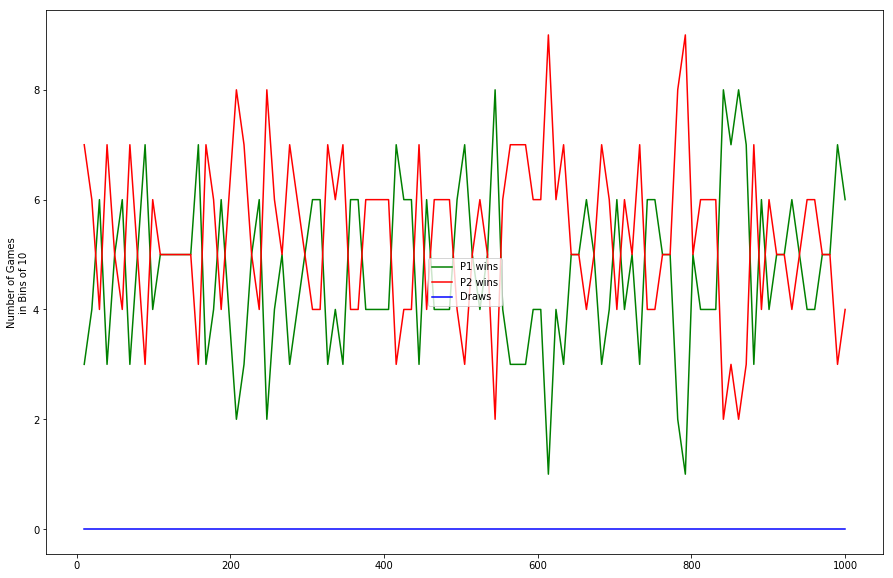

In [30]:
plot_outcomes(outcomes3, 1000, 1000)

In [31]:
state = make_move(make_move(make_move(make_move(make_move(make_move([0]*24, 0), 3), 12), 13), 1), 4)
print_game(state)
moves = valid_moves(state)

•---•---•   •
|   |
•---•---•   •

•   •   •   •

•   •   •   •


In [32]:
Qs = [Qnet1.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to first neural network')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to first neural network')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to first neural network
•---•---•   •
|   |
•---•---•---•

•   •   •   •

•   •   •   •
Best move for player 2 according to first neural network
•---•---•   •
|   |
•---•---•   •

•   •   •   •
   |
•   •   •   •


In [33]:
Qs = [Qnet2.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to second neural network')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to second neural network')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to second neural network
•---•---•   •
|   |
•---•---•---•

•   •   •   •

•   •   •   •
Best move for player 2 according to second neural network
•---•---•   •
|   |
•---•---•   •

•   •   •   •
   |
•   •   •   •


In [34]:
Qs = [Qnet3.use_pytorch(torch.from_numpy(np.array(state + [m])).double()) for m in moves]
print('Best move for player 1 according to third neural network')
print_game(make_move(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to third neural network')
print_game(make_move(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to third neural network
•---•---•   •
|   |
•---•---•   •

•   •   •   •

•   •---•   •
Best move for player 2 according to third neural network
•---•---•   •
|   |
•---•---•   •

•   •   •   •
   |
•   •   •   •
